# 0.0. IMPORTS

In [102]:
import pandas as pd
import numpy as np

import seaborn                as sns
import matplotlib.pyplot      as plt

from sqlalchemy import create_engine
import sqlite3

import warnings

In [7]:
#method to display all columns and rows
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
warnings.filterwarnings('ignore')

## 0.1. Loading Data

In [2]:
df_raw = pd.read_csv("claims.csv")

In [4]:
df_raw.head()

,claim_number,email,phone_number,claim_date,cost
0,G269475,BobR8@gmail.com,(640) 065-0964,2018-07-11,0
1,R246552,GaryM7@gmail.com,(382) 379-5739,2018-03-03,985376
2,U548,TravisD9@gmail.com,(559) 200-5939,2018-11-09,651813
3,H498573,CindyT2@gmail.com,(909) 492-4494,2018-01-03,568141
4,L94564,JudeD0@gmail.com,(743) 137-5740,2018-02-22,0


### Summary

- claim_number: a unique indicator for a claim
- email: Claiment email
- phone_number: Claiment phone number
- claim_date: Claim date
- cost: cost == 0 indicates that the claim was rejected and is a reasonable response

# 1.0. DATA DESCRIPTION

In [18]:
df1 = df_raw.copy()

## 1.1. Data Dimension

Let's understand how big our dataset is. This will be important because a robust machine learning model needs a considerable amount of data to train our algorithm. As you can see below, we have 1000 rows and 5 columns.

In [19]:
#Check number of columns and number of rows
print(f"Number of Columns: {df1.shape[1]}")
print(f"Number of Rows: {df1.shape[0]}")

Number of Columns: 5
Number of Rows: 1000


## 1.2. Change types

This step is important for us to understand what is the type of our features. Therefore, we need to treat each variable according to its specific type ... for example, we cannot treat a date as a number or as a text, we cannot treat a number as a text. It is necessary for us to understand the context of our business for the changes to be made.

As we can see below, our columns "claim_date" is like a "object"...we will change it to "datetime" type.

In [20]:
df1.dtypes

claim_number    object
email           object
phone_number    object
claim_date      object
cost             int64
dtype: object

In [21]:
df1.head()

,claim_number,email,phone_number,claim_date,cost
0,G269475,BobR8@gmail.com,(640) 065-0964,2018-07-11,0
1,R246552,GaryM7@gmail.com,(382) 379-5739,2018-03-03,985376
2,U548,TravisD9@gmail.com,(559) 200-5939,2018-11-09,651813
3,H498573,CindyT2@gmail.com,(909) 492-4494,2018-01-03,568141
4,L94564,JudeD0@gmail.com,(743) 137-5740,2018-02-22,0


In [22]:
#change claim_date to datetime
df1['claim_date'] = pd.to_datetime(df1['claim_date'])

## 1.3. Check Missing Values

This step is extremely important because our machine learning algorithms are not able of handling null values. To solve this problem there is no right answer, it will depend on your business context, we have to be aware of it and test what will be best suited to that situation. There are three ways to fix this.

Exclude lines with null values.
Replace with the average or median, for example.
Change according to the business context.
This choice is very important because, if we choose to exclude the rows from our data set, depending on the amount of null values, we will eliminate a considerable amount of data so that our model could train.

In [23]:
#check NA 
df1.isnull().sum().sort_values(ascending = False).head(30)

claim_number    1
email           0
phone_number    0
claim_date      0
cost            0
dtype: int64

In [27]:
#remove any entries without claim_number
df1 = df1.loc[~df1['claim_number'].isna(),:]

In [28]:
df1.shape

(999, 5)

## 1.4. Descriptive Statistical

This step is essential. It is necessary that we separate the numerical variables from the categorical variables. Because each will have a different form of analysis.

In [30]:
num_attributes = df1.select_dtypes(include = ['int64','float64'])

For the numerical variables we use two types of analysis.

Central tendency

- average
- median
- Dispersion

std - standard deviation
- min
- max
- range
- skew
- kurtosis

In [33]:
#Central Tendency - Mean, Median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispersion - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T


m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,cost,0.000,999999999999.000,999999999999.000,10010358932.251,295840.000,99547992065.484,9.859,95.393


- High standard deviation;
- Median too far from the mean, indicates a high dispersion in the data.
- We can filter the outliers.

In [53]:
df1['cost'].describe(percentiles=[0.75])

count            999.000
mean     10010358932.251
std      99597853321.836
min                0.000
50%           295840.000
75%           653670.000
max     999999999999.000
Name: cost, dtype: float64

Text(0.5, 1.0, 'After Filtering')

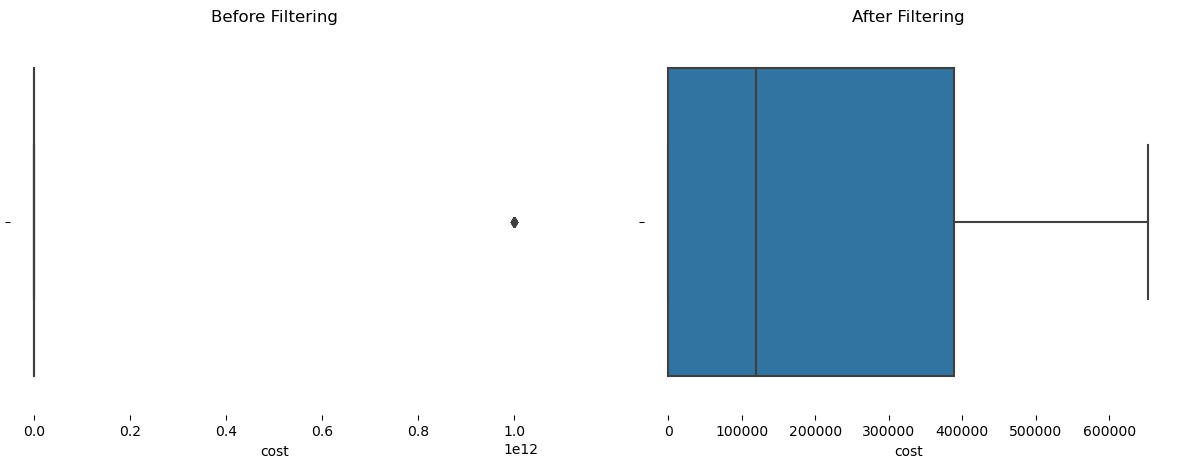

In [55]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
sns.boxplot(x = 'cost', data = df1)
plt.box(False)
plt.title("Before Filtering")

aux_df = df1[df1['cost'] <= 653670]
plt.subplot(1,2,2)
sns.boxplot(x = 'cost', data = aux_df)
plt.box(False)
plt.title("After Filtering")

# 2.0. FEATURE ENGINEERING

To compose this step, we created a mind map hypothesis. It's a easy tool to visualize every opinions about our business context. So, we'll create some features that will be useful in the exploratory data analysis and to get some insights, useful to understand what is the influence of each variable to our prediction variable. This step is useful to have organized data.

In [63]:
df2 = df1.copy()

In [66]:
df2['claim_approved'] = df2['cost'].apply(lambda x: 1 if x > 0 else 0)

In [79]:
# year
df2['year'] = df2['claim_date'].dt.year

# month
df2['month'] = df2['claim_date'].dt.month

# day
df2['day'] = df2['claim_date'].dt.day

# week of year
df2['week_of_year'] = df2['claim_date'].dt.weekofyear

# year week
df2['year_week'] = df2['claim_date'].dt.strftime( '%Y-%W' )

# 3.0. EXPLORATORY DATA ANALYSIS

In [80]:
#checkpoint
df3 = df2.copy()

## 3.1. Univariate Analysis

Univariate analysis is the most basic form of statistical data analysis technique. When the data contains only one variable and doesn’t deal with a causes or effect relationships then a Univariate analysis technique is used.

### 3.1.1. Response Variable

We built a distplot to see how our response variable is distributed. As we can see, it is close to a normal distribution, however, it has a positive skewness, so it is shifted to the left. It is important to understand that machine learning, cost function or a neuron potential values are the quantities that are expected to be the sum of many independent processes (such as input features or activation potential of last layer) often have distributions that are nearly normal.

Text(0.5, 1.0, 'After Filtering')

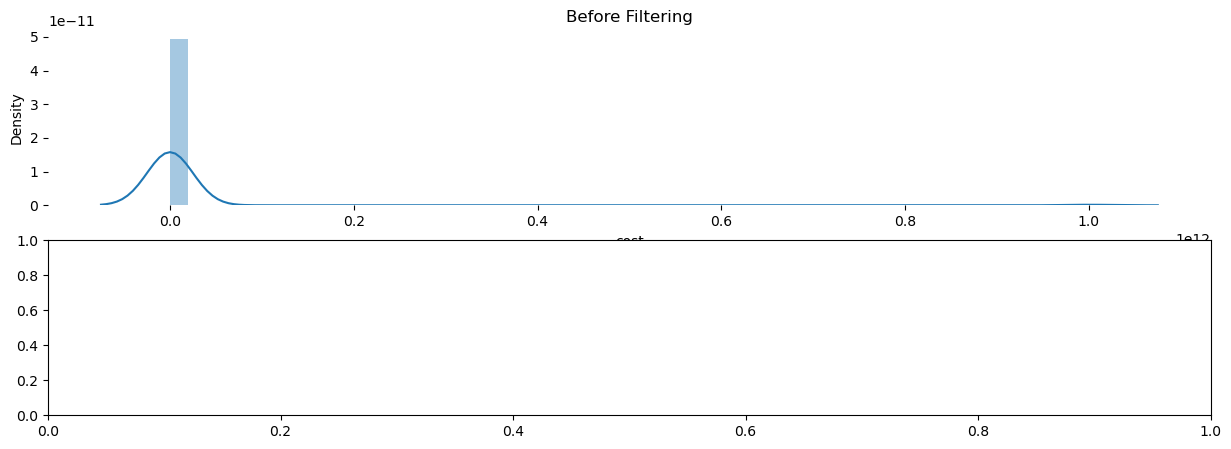

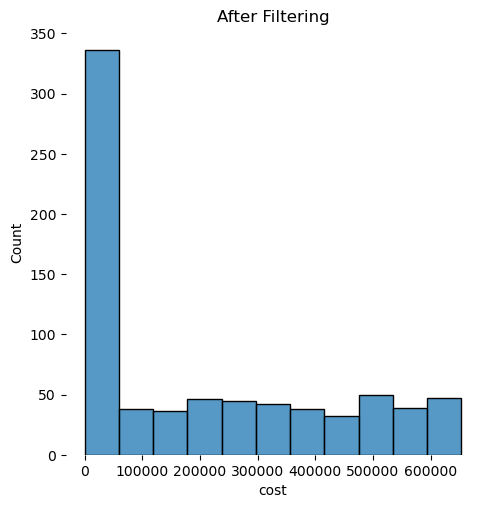

In [69]:
plt.figure(figsize = (15,5))
plt.subplot(2,1,1)
sns.distplot(df3['cost'])
plt.box(False)
plt.title("Before Filtering")


aux_df = df3[df3['cost'] <= 653670]
plt.subplot(2,1,2)
sns.displot(aux_df['cost'])
plt.box(False)
plt.title("After Filtering")

- This allows us to visualize that there is a strong concentration of claims that were denied, being quite representative.
- In relation to the other values, there is not a very sudden variation in their respective percentages

### 3.1.2. Numerical Variables

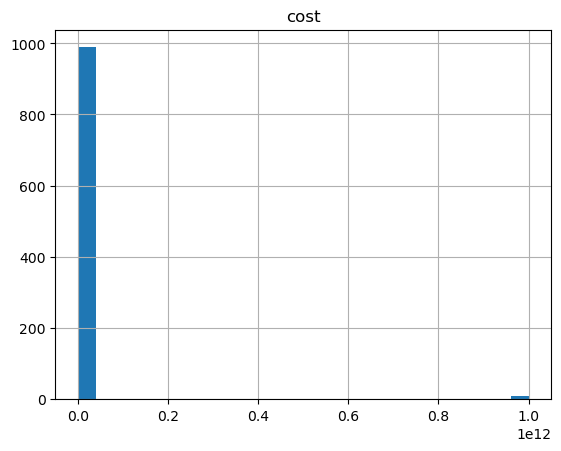

In [72]:
num_attributes.hist(bins = 25);

### 3.1.3. Categorical Variables

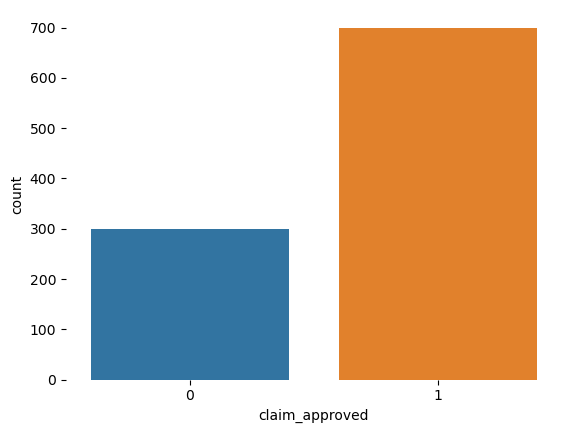

In [75]:
sns.countplot(df3['claim_approved'])
plt.box(False)

In [77]:
df3['claim_approved'].value_counts(1)

1   0.701
0   0.299
Name: claim_approved, dtype: float64

- 70% of claims were approved.

## 3.2. Bivariante Analysis

### 3.2.1. Year_week x Cost

<Figure size 2500x700 with 0 Axes>

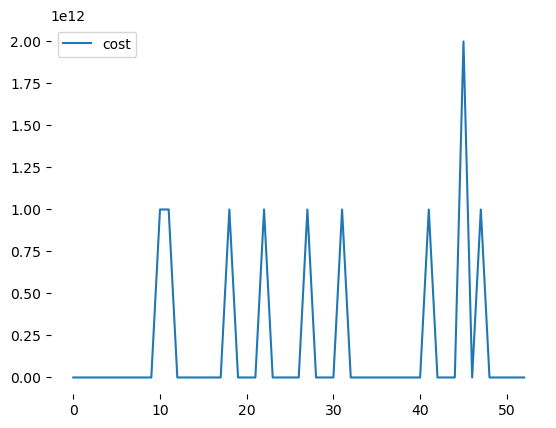

In [87]:
plt.figure(figsize = (25,7))
aux1 = df3[['year_week','cost']].groupby('year_week').sum().reset_index()
aux1.plot()
plt.box(False)

- There are weeks of the year when claims are not approved

In [92]:
df3.head()

,claim_number,email,phone_number,claim_date,cost,claim_approved,year,month,day,week_of_year,year_week
0,G269475,BobR8@gmail.com,(640) 065-0964,2018-07-11,0,0,2018,7,11,28,2018-28
1,R246552,GaryM7@gmail.com,(382) 379-5739,2018-03-03,985376,1,2018,3,3,9,2018-09
2,U548,TravisD9@gmail.com,(559) 200-5939,2018-11-09,651813,1,2018,11,9,45,2018-45
3,H498573,CindyT2@gmail.com,(909) 492-4494,2018-01-03,568141,1,2018,1,3,1,2018-01
4,L94564,JudeD0@gmail.com,(743) 137-5740,2018-02-22,0,0,2018,2,22,8,2018-08


# 4.0. SAVE TO DATABASE

In [110]:
df4 = df3.copy()

In [114]:
df4 = df4[['claim_number', 'email', 'phone_number', 'claim_date', 'cost']]

In [115]:
conn = sqlite3.connect('claims.db')
df4.to_sql('claims', conn, if_exists="replace", index={'claim_number': True})

999